# Openclassrooms PJ5 : Online Retail dataset :  modelisation notebook 

In [125]:
%matplotlib inline

#%load_ext autoreload  # Autoreload has a bug : when you modify function in source code and run again, python kernel hangs :(
#%autoreload 2

import datetime as dt

import sys, importlib

from functions import *
importlib.reload(sys.modules['functions'])

import pandas as pd

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

import datetime as dt

import os
import zipfile
import urllib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import qgrid

import glob

from pandas.plotting import scatter_matrix

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.model_selection import GridSearchCV

from sklearn.manifold import TSNE

DATA_PATH = os.path.join("datasets", "onlineretail")
DATA_PATH = os.path.join(DATA_PATH, "out")

DATA_PATH_FILE_INPUT = os.path.join(DATA_PATH, "OnlineRetail_transformed.csv")


ALL_FEATURES = []

#MODEL_FEATURES=['InvoiceNo', 'InvoiceDate', 'CustomerID', 'TotalPrice', 'DescriptionNormalized', 'InvoiceMonth', 'StockCode']
MODEL_CLIENT_FEATURES = ['TotalPricePerMonth', 'DescriptionNormalized', 'HasEverCancelled', 'BoughtTopValueProduct' ]

plt.rcParams["figure.figsize"] = [16,9] # Taille par défaut des figures de matplotlib

import seaborn as sns
sns.set()

#import common_functions

####### Paramètres pour sauver et restaurer les modèles :
import pickle
####### Paramètres à changer par l'utilisateur selon son besoin :

RECOMPUTE_GRIDSEARCH = True  # CAUTION : computation is several hours long
SAVE_GRID_RESULTS = False # If True : grid results object will be saved to pickle files that have GRIDSEARCH_FILE_PREFIX
LOAD_GRID_RESULTS = False # If True : grid results object will be loaded from pickle files that have GRIDSEARCH_FILE_PREFIX
                          # Grid search results are loaded with full samples (SAMPLED_DATA must be False)

'''
RECOMPUTE_GRIDSEARCH = True  # CAUTION : computation is several hours long
SAVE_GRID_RESULTS = True # If True : grid results object will be saved to pickle files that have GRIDSEARCH_FILE_PREFIX
LOAD_GRID_RESULTS = False # If True : grid results object will be loaded from pickle files that have GRIDSEARCH_FILE_PREFIX
'''
#GRIDSEARCH_CSV_FILE = 'grid_search_results.csv'

GRIDSEARCH_FILE_PREFIX = 'grid_search_results_'

EXECUTE_INTERMEDIATE_MODELS = True # If True: every intermediate model (which results are manually analyzed in the notebook) will be executed


# Necessary for predictors used in the notebook :
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import PolynomialFeatures

### For progress bar :
from tqdm import tqdm_notebook as tqdm

# Statsmodel : 
import statsmodels.formula.api as smf

import statsmodels.api as sm
from scipy import stats

SAVE_API_MODEL = True # If True : API model ill be saved
API_MODEL_PICKLE_FILE = 'API_model_PJ5.pickle'


# Load data

In [2]:
df = load_data(DATA_PATH_FILE_INPUT)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399912 entries, 0 to 399911
Data columns (total 11 columns):
InvoiceNo                399912 non-null object
StockCode                399912 non-null object
Description              399912 non-null object
Quantity                 399912 non-null int64
InvoiceDate              399912 non-null object
UnitPrice                399912 non-null float64
CustomerID               399912 non-null object
Country                  399912 non-null object
TotalPrice               399912 non-null float64
DescriptionNormalized    399912 non-null object
InvoiceMonth             399912 non-null object
dtypes: float64(2), int64(1), object(8)
memory usage: 33.6+ MB


In [4]:
df, df_train, df_test = custom_train_test_split_sample(df, 'TotalPrice')

In [5]:
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359920 entries, 0 to 359919
Data columns (total 12 columns):
index                    359920 non-null int64
InvoiceNo                359920 non-null object
StockCode                359920 non-null object
Description              359920 non-null object
Quantity                 359920 non-null int64
InvoiceDate              359920 non-null object
UnitPrice                359920 non-null float64
CustomerID               359920 non-null object
Country                  359920 non-null object
TotalPrice               359920 non-null float64
DescriptionNormalized    359920 non-null object
InvoiceMonth             359920 non-null object
dtypes: float64(2), int64(2), object(8)
memory usage: 33.0+ MB


In [7]:
df_train_ori = df_train.copy(deep=True)
df_test_ori = df_test.copy(deep=True)

# Top value products (must be saved with the model, and passed to it)

In [8]:
df_nocancel = df_train[df_train['InvoiceNo'].str.startswith('C') == False]
df_nocancel.reset_index(inplace=True)

df_gbproduct = df_nocancel[['StockCode', 'TotalPrice']].groupby('StockCode').sum()['TotalPrice']

In [9]:
TOP_VALUE_PRODUCT_THRESHOLD = 20
top_value_products = df_gbproduct.sort_values(ascending=False).head(TOP_VALUE_PRODUCT_THRESHOLD).index  # Get top value products

In [10]:
top_value_products

Index(['23843', '22423', '85123A', '23166', '85099B', '47566', '84879',
       '23084', '79321', '21137', '22386', '22086', '23203', '23298', '22197',
       '22720', '82484', '22960', '23284', '22470'],
      dtype='object', name='StockCode')

# Preparation pipeline : model with bow features + TotalPricePerMonth + BoughtTopValueProduct + HasEverCancelled

In [11]:
importlib.reload(sys.modules['functions'])
from functions import *

In [93]:
df_train = df_train_ori
df_test = df_test_ori


In [13]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='PCA', n_dim=200)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [14]:
df_train = preparation_pipeline.fit_transform(df_train)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Fit log scaler multiple
Transform log scaler scaler multiple
Fit Min max scaler multiple
Transform Min max scaler multiple
Fit Dimensionality Reductor
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNo

In [15]:
df_test = preparation_pipeline.transform(df_test)

Transform data
Transform log scaler scaler multiple
Transform Min max scaler multiple
Transform Dimensionality Reductor
Remaining columns: ['BoughtTopValueProduct', 'TotalPricePerMonth', 'HasEverCancelled']
Transform Min max scaler multiple


In [16]:
df_train

,BoughtTopValueProduct,TotalPricePerMonth,HasEverCancelled,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,...,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1.0,0.877446,1.0,0.012337,0.471255,0.453895,0.473793,0.422514,0.477428,0.511300,0.621569,0.503611,0.457645,0.488108,0.409855,0.507048,0.489916,0.535120,0.450122,0.416282,0.433797,0.443093,0.493141,0.412239,0.427322,0.473147,0.432088,0.528820,0.450200,0.459886,0.473117,0.433168,0.488465,0.503132,0.399987,0.584633,0.447537,0.492541,0.517062,0.377510,0.529313,0.459306,0.523139,0.469704,0.504570,0.398279,0.542894,0.429799,0.399044,0.521399,0.543306,0.450327,0.418836,0.431200,0.490354,0.542884,0.509923,0.367388,0.437391,0.425607,0.512488,0.372301,0.498315,0.475286,0.437260,0.480143,0.587004,0.486567,0.388474,0.501430,0.392958,0.416430,0.440610,0.521534,0.475764,0.503541,0.470143,0.554051,0.458118,0.444796,0.579487,0.511475,0.500357,0.520831,0.540307,0.518675,0.475360,0.451498,0.462396,0.445466,0.563011,0.523718,0.507242,0.492180,0.542538,0.412135,0.506521,0.466998,0.446677,0.544778,...,0.475080,0.502716,0.507566,0.533228,0.419587,0.506973,0.439612,0.397676,0.465354,0.502752,0.519376,0.466410,0.412631,0.440697,0.464944,0.461278,0.529768,0.551024,0.491373,0.374818,0.474981,0.442860,0.531087,0.522520,0.483613,0.435952,0.479664,0.439030,0.430370,0.425685,0.431509,0.495010,0.456704,0.611366,0.489188,0.451873,0.463615,0.469538,0.478288,0.449052,0.448172,0.513638,0.459082,0.543429,0.392742,0.421414,0.469708,0.523621,0.437486,0.498244,0.431518,0.475198,0.445919,0.458436,0.451155,0.469181,0.499680,0.487091,0.513722,0.478585,0.480089,0.406455,0.438537,0.506440,0.543998,0.497588,0.475607,0.507814,0.429530,0.491585,0.442403,0.500218,0.444192,0.414449,0.382706,0.432884,0.471343,0.423740,0.497835,0.442837,0.491193,0.503871,0.406054,0.402640,0.467203,0.480021,0.421236,0.453207,0.477320,0.452785,0.500901,0.551835,0.500806,0.423743,0.454834,0.470665,0.460762,0.472572,0.475373,0.508569
1,1.0,0.572415,0.0,0.356103,0.422611,0.371563,0.401205,0.423753,0.459667,0.244693,0.315722,0.324954,0.332584,0.361404,0.446291,0.447552,0.669808,0.790530,0.482239,0.576480,0.752849,0.562928,0.737228,0.470412,0.526429,0.381535,0.560372,0.457751,0.378714,0.394398,0.411156,0.531468,0.580524,0.551032,0.628469,0.473163,0.278413,0.419166,0.597061,0.558633,0.443851,0.486657,0.723625,0.535719,0.164400,0.374890,0.309930,0.571018,0.698841,0.418857,0.153259,0.769953,0.480305,0.649835,0.708358,0.469181,0.160876,0.613881,0.763376,0.353395,0.175009,0.405079,0.429308,0.674004,0.588716,0.523247,0.208890,0.620054,0.432720,0.766373,0.187645,0.357195,0.651960,0.842733,0.593161,0.412449,0.520616,0.235204,0.448366,0.589982,0.654690,0.426400,0.266607,0.487119,0.327966,0.061868,0.263894,0.339949,0.566899,0.691232,0.504976,0.407123,0.755090,0.456061,0.549219,0.319391,0.721696,0.623675,0.085439,0.434467,...,0.396648,0.351192,0.567467,0.595246,0.264374,0.509042,0.589848,0.378488,0.421981,0.465041,0.568957,0.168215,0.550435,0.587881,0.587852,0.461770,0.589192,0.612656,0.412207,0.476473,0.400172,0.389585,0.480509,0.398899,0.566096,0.478924,0.687234,0.557866,0.471353,0.468082,0.409991,0.291709,0.481824,0.370998,0.322629,0.405253,0.626431,0.289169,0.280553,0.595379,0.542844,0.337529,0.519277,0.714039,0.187666,0.457129,0.546048,0.326732,0.640892,0.330897,0.440485,0.467915,0.755505,0.544594,0.450295,0.688021,0.526555,0.851191,0.579849,0.578832,0.628698,0.329673,0.5303

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Columns: 203 entries, BoughtTopValueProduct to 199
dtypes: float64(203)
memory usage: 6.7 MB


# Explained variance of bag of words features

In [18]:
from display_factorial import *
importlib.reload(sys.modules['display_factorial'])

<module 'display_factorial' from '/home/francois/coding/OC/PJ5/display_factorial.py'>

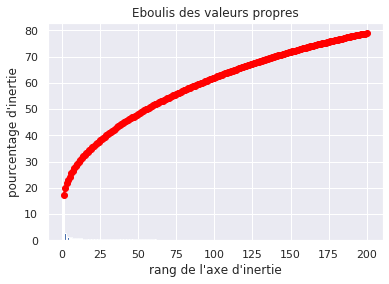

In [19]:
display_scree_plot(preparation_pipeline['dimensionality_reductor'].reductor)

# 2D visualization

In [20]:
pca = PCA(n_components=2, random_state=42)
X_transformed = pca.fit_transform(df_train)
X_test_transformed = pca.fit_transform(df_test)

In [21]:
X_transformed[:,1]

array([ 0.24692735, -0.47828001,  0.28147071, ...,  0.22990649,
       -0.46182225,  0.28015663])

In [22]:
print('Binarisation of color categories')
bins = [-np.inf,df_train['TotalPricePerMonth'].quantile(0.25),\
        df_train['TotalPricePerMonth'].quantile(0.50),\
        df_train['TotalPricePerMonth'].quantile(0.75),\
        df_train['TotalPricePerMonth'].quantile(1)]

labels = [0, 1, 2, 3]

df_score_cat_train = pd.cut(df_train['TotalPricePerMonth'], bins=bins, labels=labels)


bins = [-np.inf,df_test['TotalPricePerMonth'].quantile(0.25),\
        df_test['TotalPricePerMonth'].quantile(0.50),\
        df_test['TotalPricePerMonth'].quantile(0.75),\
        df_test['TotalPricePerMonth'].quantile(1)]

labels = [0, 1, 2, 3]

df_score_cat_test = pd.cut(df_test['TotalPricePerMonth'], bins=bins, labels=labels)

Binarisation of color categories


Text(0, 0.5, 'Axe 2')

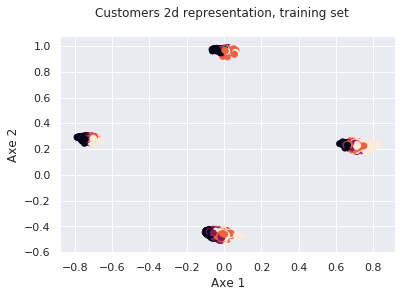

In [23]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [24]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients.html') 

'clusters_plot_clients.html'

Text(0, 0.5, 'Axe 2')

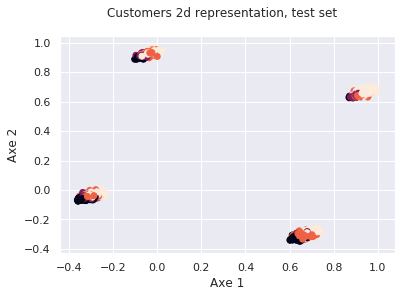

In [25]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, test set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_test_transformed[:,0], X_test_transformed[:,1], c=df_score_cat_test)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

# Model with only bag of word features

In [66]:
importlib.reload(sys.modules['functions'])
from functions import *

In [67]:
df_train = df_train_ori
df_test = df_test_ori


In [68]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    #('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    #('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='PCA', n_dim=200)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [69]:
df_train = preparation_pipeline.fit_transform(df_train)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNormalized_your', 'DescriptionNormalized_zinc'],
      dtype='object', length=601)
Fit Dimensionality Reductor
Features selected (in order): Index(['Desc

In [70]:
df_test = preparation_pipeline.transform(df_test)

Transform data
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNormalized_your', 'DescriptionNormalized_zinc'],
      dtype='object', length=601)
Transform Dimensionality Reductor
Remaining columns: []
Transform Min max scaler multiple


In [71]:
df_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,0.012337,0.471255,0.453895,0.473792,0.422515,0.477428,0.511300,0.621573,0.503603,0.457636,0.488107,0.409851,0.507039,0.489924,0.535097,0.450113,0.416231,0.433651,0.443082,0.493141,0.412320,0.427212,0.473089,0.432029,0.528886,0.450117,0.459842,0.472977,0.433169,0.488372,0.503215,0.400208,0.584710,0.447645,0.492682,0.517034,0.378140,0.529628,0.458958,0.522559,0.469242,0.504533,0.398821,0.543445,0.430107,0.399396,0.522238,0.544145,0.449648,0.417072,0.431543,0.490093,0.542894,0.510918,0.366570,0.440053,0.425135,0.511159,0.373581,0.495101,0.472183,0.438065,0.476713,0.589193,0.484619,0.387438,0.505040,0.394864,0.422856,0.442088,0.516032,0.471642,0.493630,0.470901,0.559692,0.452431,0.445378,0.585188,0.511777,0.501484,0.518820,0.459496,0.521868,0.478501,0.457374,0.465749,0.431132,0.560813,0.519439,0.501016,0.513445,0.543238,0.404014,0.507493,0.463213,0.432081,0.445571,0.488089,0.457074,0.516116,0.484621,0.509055,0.524829,0.548928,0.503491,0.505590,0.414589,0.400337,0.492786,0.473533,0.522883,0.476010,0.420513,0.440184,0.478178,0.473667,0.460866,0.415865,0.517874,0.557733,0.500095,0.463860,0.507113,0.531900,0.496001,0.443802,0.481966,0.438100,0.475301,0.433769,0.498795,0.463774,0.546386,0.560000,0.406681,0.489125,0.478952,0.460355,0.502669,0.508425,0.483879,0.478176,0.521802,0.601644,0.425037,0.437860,0.502261,0.485847,0.432998,0.510636,0.400200,0.544221,0.483034,0.478746,0.464106,0.432295,0.504526,0.374051,0.526394,0.472195,0.484909,0.468217,0.474777,0.487993,0.496821,0.493211,0.450990,0.482316,0.527529,0.493681,0.477003,0.507089,0.498896,0.419216,0.506179,0.482797,0.460594,0.504109,0.500341,0.494706,0.450295,0.469208,0.444999,0.514131,0.493791,0.422157,0.523184,0.459016,0.441821,0.509345,0.431423,0.501690,0.433528,0.496374,0.462058,0.495110,0.561519,0.451549,0.470147,0.484219
1,0.356103,0.422611,0.371563,0.401205,0.423753,0.459667,0.244696,0.315723,0.324960,0.332557,0.361402,0.446273,0.447569,0.669799,0.790450,0.482236,0.576470,0.752625,0.562955,0.737329,0.470514,0.526105,0.381615,0.560234,0.457749,0.378667,0.394523,0.411299,0.531320,0.580159,0.551038,0.628249,0.473172,0.279293,0.419160,0.597606,0.559283,0.443837,0.486350,0.721361,0.537234,0.165480,0.375139,0.309807,0.571432,0.697603,0.420104,0.154372,0.770285,0.479405,0.651543,0.707152,0.470702,0.161564,0.616910,0.762082,0.353800,0.174293,0.408522,0.425099,0.672587,0.583929,0.524421,0.216919,0.620503,0.431454,0.769541,0.190718,0.366156,0.659157,0.830478,0.598132,0.586564,0.516048,0.239420,0.420294,0.590145,0.651352,0.430805,0.258808,0.480250,0.677875,0.070683,0.289637,0.344087,0.566167,0.679748,0.474887,0.407428,0.752334,0.489031,0.532303,0.310517,0.705956,0.600683,0.038616,0.620654,0.335350,0.324779,0.448885,0.405150,0.345451,0.605803,0.621136,0.415211,0.576715,0.557088,0.377508,0.440909,0.524311,0.520423,0.183969,0.493169,0.605005,0.583771,0.371131,0.399397,0.341477,0.393157,0.454153,0.480698,0.423187,0.541739,0.405219,0.591268,0.509745,0.578376,0.594432,0.566553,0.452708,0.456449,0.279545,0.389416,0.288723,0.475549,0.549800,0.304535,0.683448,0.484016,0.351578,0.646563,0.549726,0.629460,0.675521,0.120935,0.701723,0.681827,0.392288,0.565798,0.462422,0.493782,0.422761,0.436076,0.177535,0.155651,0.585697,0.505687,0.263383,0.223041,0.652910,0.526143,0.515587,0.414626,0.251649,0.534964,0.795438,0.295696,0.

In [72]:
pca = PCA(n_components=2, random_state=42)
X_transformed = pca.fit_transform(df_train)
X_test_transformed = pca.fit_transform(df_test)

Text(0, 0.5, 'Axe 2')

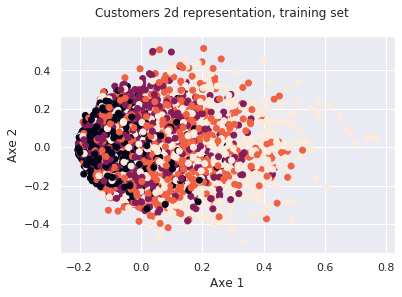

In [74]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set, BoW')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [76]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_score_cat_train,
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_onlybow.html') 

'clusters_plot_clients_onlybow.html'

# Model with bow features + TotalPricePerMonth

In [77]:
importlib.reload(sys.modules['functions'])
from functions import *

In [78]:
df_train = df_train_ori
df_test = df_test_ori


In [79]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    #('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    #('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='PCA', n_dim=200)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [80]:
df_train = preparation_pipeline.fit_transform(df_train)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_word', 'DescriptionNormalized_world',
       'DescriptionNormalized_wrap', 'DescriptionNormalized_wreath',
       'DescriptionNormalized_writing', 'DescriptionNormalized_yellow',
       'DescriptionNormalized_you', 'DescriptionNormalized_your',
       'DescriptionNormalized_zinc', 'TotalPricePerMonth'],
      dtype='object', length=602)
Fit Dimensionality Reductor
Features selected (in order): Index(['DescriptionNorma

In [81]:
df_test = preparation_pipeline.transform(df_test)

Transform data
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_word', 'DescriptionNormalized_world',
       'DescriptionNormalized_wrap', 'DescriptionNormalized_wreath',
       'DescriptionNormalized_writing', 'DescriptionNormalized_yellow',
       'DescriptionNormalized_you', 'DescriptionNormalized_your',
       'DescriptionNormalized_zinc', 'TotalPricePerMonth'],
      dtype='object', length=602)
Transform Dimensionality Reductor
Remaining columns: ['TotalPricePerMonth']
Transform Min max scaler multiple


In [82]:
df_train

,TotalPricePerMonth,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,...,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,0.289049,0.012337,0.471255,0.453895,0.473792,0.422514,0.477428,0.511301,0.621574,0.503607,0.457638,0.488114,0.409845,0.507030,0.489934,0.535087,0.450095,0.416230,0.433673,0.443131,0.493133,0.412197,0.427241,0.473065,0.432138,0.528761,0.450307,0.459692,0.473168,0.433151,0.488504,0.503131,0.400308,0.584578,0.447930,0.492392,0.516888,0.377799,0.529068,0.458995,0.522684,0.469415,0.504471,0.399160,0.542828,0.428481,0.400050,0.522399,0.543842,0.449494,0.418428,0.431399,0.490945,0.543988,0.509597,0.364525,0.552922,0.426117,0.511676,0.375344,0.494454,0.475901,0.438172,0.476631,0.588888,0.487003,0.390005,0.504968,0.393889,0.420760,0.439296,0.522429,0.481905,0.492591,0.467323,0.561648,0.462999,0.445302,0.567919,0.512605,0.502936,0.521781,0.544246,0.507972,0.480700,0.458782,0.462895,0.447655,0.564196,0.517726,0.508501,0.511135,0.541353,0.397816,0.472654,0.462728,0.562378,0.548333,0.480679,0.439073,...,0.465435,0.509688,0.524196,0.546928,0.464398,0.483233,0.440180,0.402081,0.473200,0.462525,0.531775,0.463396,0.410125,0.460472,0.482462,0.454911,0.461115,0.398554,0.512410,0.381797,0.484460,0.469790,0.465618,0.568746,0.447456,0.415986,0.527627,0.477807,0.465066,0.493201,0.522835,0.455198,0.427343,0.426039,0.412442,0.504919,0.523668,0.515675,0.460291,0.504012,0.442154,0.511188,0.496224,0.452220,0.364609,0.453592,0.454275,0.468563,0.489853,0.424056,0.510313,0.464727,0.497895,0.441945,0.557257,0.454042,0.435655,0.512691,0.450975,0.493498,0.476525,0.529729,0.359828,0.435303,0.474676,0.475315,0.364308,0.475394,0.444150,0.467381,0.434183,0.458895,0.468688,0.523063,0.463093,0.484512,0.439550,0.515585,0.420008,0.494570,0.377781,0.489370,0.482629,0.525561,0.517038,0.506864,0.476477,0.441271,0.451301,0.445318,0.468253,0.470200,0.501334,0.491308,0.500310,0.454911,0.470233,0.471592,0.457313,0.451886
1,0.013128,0.356103,0.422611,0.371563,0.401205,0.423753,0.459668,0.244698,0.315724,0.324962,0.332572,0.361413,0.446290,0.447551,0.669799,0.790468,0.482202,0.576478,0.752705,0.562986,0.737295,0.470293,0.526202,0.381501,0.560370,0.457827,0.378792,0.394304,0.411298,0.531270,0.580652,0.551246,0.628877,0.473228,0.278902,0.419054,0.597288,0.559303,0.443409,0.486249,0.722243,0.535596,0.164608,0.375416,0.309943,0.570915,0.698093,0.419743,0.154472,0.769602,0.480547,0.650866,0.709090,0.469595,0.161357,0.621444,0.236348,0.356286,0.174955,0.409658,0.423941,0.678656,0.586524,0.521928,0.212790,0.621165,0.435354,0.775506,0.185189,0.361206,0.656185,0.834512,0.613515,0.579314,0.515411,0.245961,0.435397,0.591801,0.642214,0.431524,0.259416,0.496662,0.312026,0.071636,0.265534,0.327769,0.557792,0.704343,0.483045,0.411918,0.750635,0.492917,0.539533,0.315498,0.270103,0.587062,0.956369,0.397019,0.317350,0.343698,...,0.406032,0.351308,0.582627,0.606685,0.357931,0.581156,0.583934,0.367876,0.427055,0.491410,0.561639,0.157033,0.506869,0.596340,0.615591,0.367065,0.441210,0.347634,0.376160,0.437479,0.574778,0.494569,0.537561,0.447465,0.520254,0.473889,0.410026,0.660075,0.466030,0.478707,0.524401,0.346721,0.570259,0.671438,0.482667,0.565753,0.496577,0.466280,0.765696,0.231725,0.575919,0.581873,0.552288,0.124017,0.058620,0.554749,0.566732,0.539148,0.735520,0.593519,0.462295,0.512351,0.137003,0.475215,0.384162,0.303916,0.499914,0.368894,0.634869,0.447063,0.625084,0.199086,0.412845,0.433230,0

In [83]:
pca = PCA(n_components=2, random_state=42)
X_transformed = pca.fit_transform(df_train)
X_test_transformed = pca.fit_transform(df_test)

Text(0, 0.5, 'Axe 2')

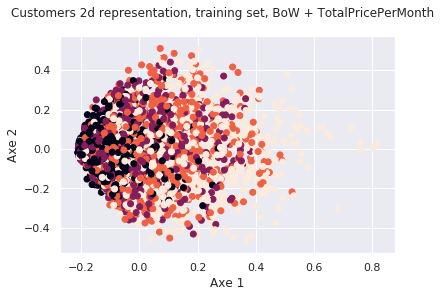

In [84]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set, BoW + TotalPricePerMonth')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [76]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_score_cat_train,
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_onlybow.html') 

'clusters_plot_clients_onlybow.html'

# Model with bow features + TotalPricePerMonth + HasEverCancelled

In [85]:
importlib.reload(sys.modules['functions'])
from functions import *

In [86]:
df_train = df_train_ori
df_test = df_test_ori


In [87]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    #('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    #('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'TotalPricePerMonth', 'HasEverCancelled'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='PCA', n_dim=200)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [88]:
df_train = preparation_pipeline.fit_transform(df_train)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNormalized_your', 'DescriptionNormalized_zinc',
       'HasEverCancelled', 'TotalPricePerMonth'],
      dtype='object', length=603)
Fit Dimensionality Reductor
Features selected (in order): Index(['DescriptionNormalized_10',

In [89]:
df_test = preparation_pipeline.transform(df_test)

Transform data
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNormalized_your', 'DescriptionNormalized_zinc',
       'HasEverCancelled', 'TotalPricePerMonth'],
      dtype='object', length=603)
Transform Dimensionality Reductor
Remaining columns: ['TotalPricePerMonth', 'HasEverCancelled']
Transform Min max scaler multiple


In [90]:
df_train

,TotalPricePerMonth,HasEverCancelled,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,...,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,0.289049,1.0,0.012337,0.471255,0.453895,0.473792,0.422515,0.477427,0.511300,0.621571,0.503609,0.457642,0.488114,0.409848,0.507019,0.489921,0.535116,0.450081,0.416261,0.433680,0.443079,0.493101,0.412234,0.427222,0.473115,0.432095,0.528662,0.450349,0.459683,0.473043,0.433043,0.488386,0.503219,0.400165,0.584644,0.447339,0.492446,0.517402,0.378147,0.529454,0.458948,0.523008,0.469525,0.504708,0.398703,0.542423,0.430423,0.399450,0.522806,0.544136,0.449268,0.417350,0.431811,0.490726,0.543470,0.511341,0.365720,0.442737,0.425911,0.511183,0.373491,0.497871,0.474463,0.436121,0.520496,0.589065,0.490190,0.387129,0.500269,0.395074,0.418316,0.439814,0.521116,0.476918,0.490543,0.470364,0.564771,0.456884,0.445442,0.580102,0.506265,0.499935,0.522289,0.456652,0.512229,0.477096,0.456908,0.471843,0.427242,0.560502,0.518928,0.505568,0.506641,0.541633,0.396344,0.508547,0.454187,0.547439,0.550481,0.487194,...,0.469393,0.494757,0.517881,0.448154,0.471341,0.511281,0.544573,0.431824,0.505530,0.463007,0.519597,0.447592,0.396073,0.534108,0.486082,0.429116,0.458010,0.406434,0.513904,0.421142,0.508640,0.478030,0.497465,0.536070,0.462373,0.459842,0.496422,0.488155,0.474382,0.447538,0.545581,0.442486,0.529133,0.418917,0.459659,0.420131,0.441768,0.455148,0.473921,0.455431,0.444032,0.456535,0.508270,0.460934,0.411770,0.497482,0.508933,0.483967,0.466184,0.474344,0.494277,0.568005,0.393523,0.469284,0.470478,0.405773,0.456599,0.456506,0.492516,0.528370,0.488392,0.472383,0.428319,0.484925,0.523129,0.419545,0.536549,0.448945,0.429917,0.402553,0.496585,0.414371,0.366623,0.548045,0.446700,0.502913,0.472559,0.512612,0.441417,0.513989,0.462109,0.470996,0.394986,0.395307,0.447376,0.481732,0.488828,0.456086,0.504348,0.482315,0.512298,0.472076,0.404526,0.505622,0.488469,0.515749,0.500136,0.413037,0.454168,0.475712
1,0.013128,0.0,0.356103,0.422611,0.371564,0.401205,0.423752,0.459667,0.244691,0.315722,0.324948,0.332579,0.361422,0.446286,0.447530,0.669840,0.790527,0.482168,0.576509,0.752755,0.562980,0.737185,0.470428,0.526145,0.381589,0.560388,0.457623,0.378759,0.394341,0.411467,0.531378,0.580195,0.550831,0.628678,0.473030,0.278025,0.418733,0.597649,0.559097,0.443811,0.485544,0.722780,0.536078,0.164874,0.376020,0.307288,0.570408,0.697316,0.421296,0.153271,0.771668,0.481631,0.650101,0.708561,0.468948,0.159915,0.619956,0.760864,0.353740,0.175971,0.407203,0.428327,0.675748,0.584299,0.473650,0.212950,0.631044,0.434635,0.764772,0.188975,0.354258,0.653199,0.835875,0.614872,0.569280,0.522051,0.249037,0.423931,0.593164,0.659103,0.424886,0.271416,0.492200,0.671978,0.059019,0.273826,0.355398,0.576443,0.674592,0.484835,0.403396,0.753970,0.487783,0.552672,0.300137,0.700869,0.616583,0.921338,0.405088,0.321357,...,0.386888,0.335924,0.591374,0.391013,0.371955,0.603620,0.405860,0.393147,0.462536,0.469141,0.557882,0.176613,0.540799,0.345622,0.608467,0.394216,0.359414,0.350242,0.386531,0.485924,0.438596,0.437108,0.479909,0.400875,0.505053,0.507271,0.548246,0.310203,0.549368,0.447000,0.458622,0.307950,0.316748,0.662436,0.529608,0.396119,0.673840,0.371934,0.731755,0.582690,0.403365,0.320731,0.481031,0.323930,0.136570,0.201627,0.365437,0.744726,0.591293,0.402093,0.301325,0.445366,0.315701,0.472927,0.783161,0.291816,0.366540,0.771036,0.596934,0.244871,0.614456,0.336127,0.361219,0.5605

In [91]:
pca = PCA(n_components=2, random_state=42)
X_transformed = pca.fit_transform(df_train)
X_test_transformed = pca.fit_transform(df_test)

Text(0, 0.5, 'Axe 2')

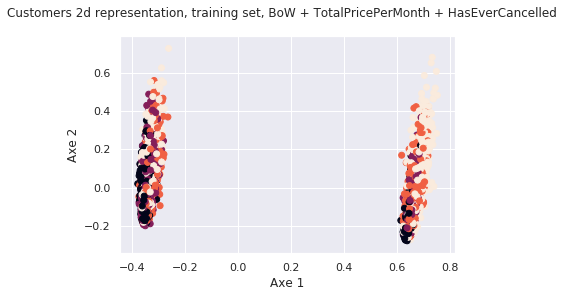

In [92]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set, BoW + TotalPricePerMonth + HasEverCancelled')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [76]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_score_cat_train,
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_onlybow.html') 

'clusters_plot_clients_onlybow.html'

# Model with all features and NCA

In [107]:
importlib.reload(sys.modules['functions'])
from functions import *

In [108]:
df_train = df_train_ori
df_test = df_test_ori

In [109]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='NCA', n_dim=200, labels_featurename='TotalPricePerMonth')),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [110]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Fit log scaler multiple
Transform log scaler scaler multiple
Fit Min max scaler multiple
Transform Min max scaler multiple
Fit Dimensionality Reductor
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNo

In [111]:
df_train

,BoughtTopValueProduct,TotalPricePerMonth,HasEverCancelled,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,...,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1.0,0.877446,1.0,0.012337,0.471255,0.453895,0.473793,0.422515,0.477429,0.511299,0.621572,0.503608,0.457640,0.488112,0.409851,0.507055,0.489921,0.535112,0.450099,0.416215,0.433678,0.443110,0.493113,0.412216,0.427219,0.473200,0.432093,0.528716,0.450216,0.459646,0.473048,0.433343,0.488316,0.503164,0.400001,0.584752,0.447438,0.492680,0.517258,0.377823,0.529196,0.459107,0.522877,0.469436,0.504345,0.398998,0.543020,0.429231,0.399796,0.521639,0.542991,0.448954,0.417234,0.431461,0.490515,0.542840,0.510726,0.361016,0.548764,0.425436,0.511753,0.375066,0.496324,0.476174,0.439224,0.479767,0.588310,0.490040,0.387545,0.504146,0.392999,0.414502,0.441010,0.517937,0.472613,0.505581,0.468415,0.561348,0.453965,0.443811,0.579750,0.507491,0.505162,0.522384,0.451964,0.505444,0.475669,0.463194,0.471138,0.428941,0.563994,0.521804,0.501732,0.519740,0.545807,0.399515,0.479424,0.457360,0.552891,0.552132,...,0.442018,0.483510,0.469831,0.555451,0.443640,0.460402,0.409701,0.402955,0.456778,0.516249,0.550767,0.487019,0.398862,0.539100,0.477272,0.455610,0.464136,0.523741,0.486981,0.566659,0.505569,0.421420,0.513580,0.501915,0.431075,0.385072,0.515873,0.499203,0.474613,0.491329,0.545118,0.483152,0.405556,0.417222,0.451988,0.429414,0.505369,0.456888,0.459098,0.492647,0.470510,0.473318,0.407703,0.528234,0.394184,0.417409,0.541471,0.492482,0.453582,0.465603,0.536188,0.409500,0.504954,0.516265,0.484865,0.436857,0.461494,0.485801,0.449288,0.498698,0.494678,0.451859,0.498233,0.463871,0.497176,0.441874,0.495599,0.496479,0.473444,0.542502,0.405203,0.462586,0.430358,0.454841,0.475705,0.448130,0.455027,0.470148,0.508721,0.432294,0.442117,0.450248,0.493644,0.469007,0.445338,0.458374,0.439820,0.449906,0.448205,0.422928,0.475765,0.498462,0.503171,0.520138,0.472351,0.472280,0.456871,0.499050,0.426913,0.469152
1,1.0,0.572415,0.0,0.356103,0.422611,0.371563,0.401206,0.423753,0.459668,0.244695,0.315718,0.324960,0.332577,0.361417,0.446315,0.447542,0.669783,0.790501,0.482164,0.576499,0.752753,0.562993,0.737260,0.470347,0.526157,0.381711,0.560419,0.457615,0.378896,0.394295,0.411293,0.531512,0.580637,0.551046,0.628213,0.473105,0.278695,0.419523,0.597281,0.559024,0.443982,0.486082,0.722544,0.536351,0.164852,0.375486,0.309871,0.571661,0.698559,0.419709,0.153834,0.769936,0.479798,0.650844,0.708143,0.469520,0.160116,0.626756,0.241120,0.358433,0.175175,0.410170,0.425278,0.679632,0.586536,0.522301,0.216822,0.632546,0.435146,0.768242,0.189217,0.355839,0.654483,0.836649,0.607627,0.416430,0.516677,0.243001,0.434406,0.592316,0.654916,0.422913,0.263274,0.487074,0.670438,0.066970,0.270752,0.346566,0.575380,0.687143,0.492310,0.405124,0.750466,0.503628,0.536841,0.306648,0.277527,0.640288,0.915704,0.427103,...,0.367640,0.309116,0.430368,0.614321,0.314971,0.423737,0.557158,0.388584,0.425230,0.503176,0.625818,0.175598,0.461695,0.402608,0.594853,0.414315,0.377087,0.565383,0.599207,0.483363,0.419228,0.439874,0.485338,0.441777,0.559043,0.463116,0.505877,0.291369,0.396165,0.481025,0.518890,0.620306,0.450874,0.694173,0.575584,0.370280,0.169377,0.525288,0.588152,0.363670,0.649533,0.520457,0.494832,0.719235,0.000690,0.522935,0.383923,0.424693,0.163552,0.523089,0.312567,0.472744,0.300414,0.124269,0.497302,0.415230,0.467584,0.328565,0.538658,0.747308,0.404553,0.737778,0.5772

In [112]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Columns: 203 entries, BoughtTopValueProduct to 199
dtypes: float64(203)
memory usage: 6.7 MB


In [114]:
pca = PCA(n_components=2,random_state=42)
X_transformed = pca.fit_transform(df_train)
X_test_transformed = pca.fit_transform(df_test)

In [115]:
X_transformed[:,1]

array([ 0.24713579, -0.48030476,  0.28160926, ...,  0.22862047,
       -0.46101204,  0.28627624])

Text(0, 0.5, 'Axe 2')

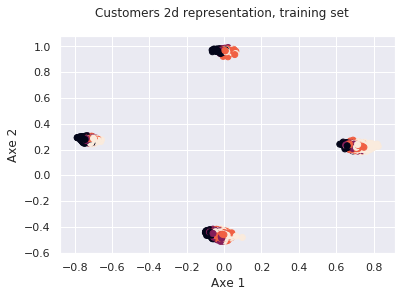

In [116]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [117]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_nca_allfeats.html') 

'clusters_plot_clients_nca_allfeats.html'

# Model with all features and NCA, final representation with tSNE

In [142]:
importlib.reload(sys.modules['functions'])
from functions import *

In [143]:
df_train = df_train_ori
df_test = df_test_ori

In [144]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='NCA', n_dim=200, labels_featurename='TotalPricePerMonth')),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [145]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Fit log scaler multiple
Transform log scaler scaler multiple
Fit Min max scaler multiple
Transform Min max scaler multiple
Fit Dimensionality Reductor
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNo

In [146]:
df_train

,BoughtTopValueProduct,TotalPricePerMonth,HasEverCancelled,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,...,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1.0,0.877446,1.0,0.012337,0.471255,0.453895,0.473793,0.422515,0.477429,0.511299,0.621572,0.503608,0.457640,0.488112,0.409851,0.507055,0.489921,0.535112,0.450099,0.416215,0.433678,0.443110,0.493113,0.412216,0.427219,0.473200,0.432093,0.528716,0.450216,0.459646,0.473048,0.433343,0.488316,0.503164,0.400001,0.584752,0.447438,0.492680,0.517258,0.377823,0.529196,0.459107,0.522877,0.469436,0.504345,0.398998,0.543020,0.429231,0.399796,0.521639,0.542991,0.448954,0.417234,0.431461,0.490515,0.542840,0.510726,0.361016,0.548764,0.425436,0.511753,0.375066,0.496324,0.476174,0.439224,0.479767,0.588310,0.490040,0.387545,0.504146,0.392999,0.414502,0.441010,0.517937,0.472613,0.505581,0.468415,0.561348,0.453965,0.443811,0.579750,0.507491,0.505162,0.522384,0.451964,0.505444,0.475669,0.463194,0.471138,0.428941,0.563994,0.521804,0.501732,0.519740,0.545807,0.399515,0.479424,0.457360,0.552891,0.552132,...,0.442018,0.483510,0.469831,0.555451,0.443640,0.460402,0.409701,0.402955,0.456778,0.516249,0.550767,0.487019,0.398862,0.539100,0.477272,0.455610,0.464136,0.523741,0.486981,0.566659,0.505569,0.421420,0.513580,0.501915,0.431075,0.385072,0.515873,0.499203,0.474613,0.491329,0.545118,0.483152,0.405556,0.417222,0.451988,0.429414,0.505369,0.456888,0.459098,0.492647,0.470510,0.473318,0.407703,0.528234,0.394184,0.417409,0.541471,0.492482,0.453582,0.465603,0.536188,0.409500,0.504954,0.516265,0.484865,0.436857,0.461494,0.485801,0.449288,0.498698,0.494678,0.451859,0.498233,0.463871,0.497176,0.441874,0.495599,0.496479,0.473444,0.542502,0.405203,0.462586,0.430358,0.454841,0.475705,0.448130,0.455027,0.470148,0.508721,0.432294,0.442117,0.450248,0.493644,0.469007,0.445338,0.458374,0.439820,0.449906,0.448205,0.422928,0.475765,0.498462,0.503171,0.520138,0.472351,0.472280,0.456871,0.499050,0.426913,0.469152
1,1.0,0.572415,0.0,0.356103,0.422611,0.371563,0.401206,0.423753,0.459668,0.244695,0.315718,0.324960,0.332577,0.361417,0.446315,0.447542,0.669783,0.790501,0.482164,0.576499,0.752753,0.562993,0.737260,0.470347,0.526157,0.381711,0.560419,0.457615,0.378896,0.394295,0.411293,0.531512,0.580637,0.551046,0.628213,0.473105,0.278695,0.419523,0.597281,0.559024,0.443982,0.486082,0.722544,0.536351,0.164852,0.375486,0.309871,0.571661,0.698559,0.419709,0.153834,0.769936,0.479798,0.650844,0.708143,0.469520,0.160116,0.626756,0.241120,0.358433,0.175175,0.410170,0.425278,0.679632,0.586536,0.522301,0.216822,0.632546,0.435146,0.768242,0.189217,0.355839,0.654483,0.836649,0.607627,0.416430,0.516677,0.243001,0.434406,0.592316,0.654916,0.422913,0.263274,0.487074,0.670438,0.066970,0.270752,0.346566,0.575380,0.687143,0.492310,0.405124,0.750466,0.503628,0.536841,0.306648,0.277527,0.640288,0.915704,0.427103,...,0.367640,0.309116,0.430368,0.614321,0.314971,0.423737,0.557158,0.388584,0.425230,0.503176,0.625818,0.175598,0.461695,0.402608,0.594853,0.414315,0.377087,0.565383,0.599207,0.483363,0.419228,0.439874,0.485338,0.441777,0.559043,0.463116,0.505877,0.291369,0.396165,0.481025,0.518890,0.620306,0.450874,0.694173,0.575584,0.370280,0.169377,0.525288,0.588152,0.363670,0.649533,0.520457,0.494832,0.719235,0.000690,0.522935,0.383923,0.424693,0.163552,0.523089,0.312567,0.472744,0.300414,0.124269,0.497302,0.415230,0.467584,0.328565,0.538658,0.747308,0.404553,0.737778,0.5772

In [147]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Columns: 203 entries, BoughtTopValueProduct to 199
dtypes: float64(203)
memory usage: 6.7 MB


In [148]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [149]:
X_transformed[:,1]

array([ 10.128316  , -10.440334  ,  -0.33006346, ...,  10.081147  ,
       -16.101868  ,   2.3950124 ], dtype=float32)

Text(0, 0.5, 'Axe 2')

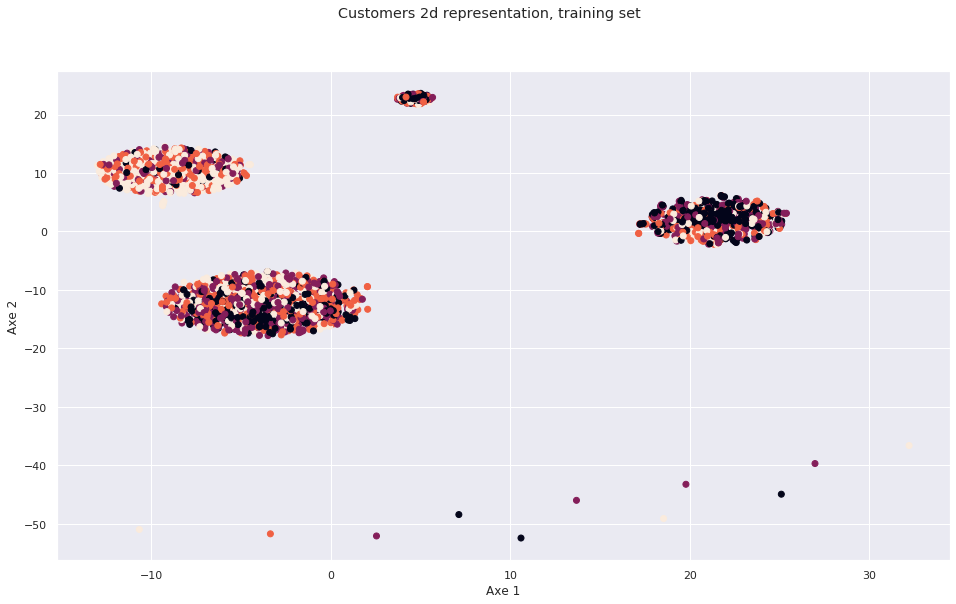

In [150]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [151]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_nca_allfeats_final_tsne.html') 

'clusters_plot_clients_nca_allfeats_final_tsne.html'

# Model with all features and PCA, final representation with tSNE

In [169]:
importlib.reload(sys.modules['functions'])
from functions import *

In [170]:
df_train = df_train_ori
df_test = df_test_ori

In [171]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='PCA', n_dim=200)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [172]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Fit log scaler multiple
Transform log scaler scaler multiple
Fit Min max scaler multiple
Transform Min max scaler multiple
Fit Dimensionality Reductor
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNo

In [173]:
df_train

,BoughtTopValueProduct,TotalPricePerMonth,HasEverCancelled,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,...,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1.0,0.877446,1.0,0.012337,0.471255,0.453895,0.473793,0.422515,0.477429,0.511299,0.621572,0.503608,0.457640,0.488112,0.409851,0.507055,0.489921,0.535112,0.450099,0.416215,0.433678,0.443110,0.493113,0.412216,0.427219,0.473200,0.432093,0.528716,0.450216,0.459646,0.473048,0.433343,0.488316,0.503164,0.400001,0.584752,0.447438,0.492680,0.517258,0.377823,0.529196,0.459107,0.522877,0.469436,0.504345,0.398998,0.543020,0.429231,0.399796,0.521639,0.542991,0.448954,0.417234,0.431461,0.490515,0.542840,0.510726,0.361016,0.548764,0.425436,0.511753,0.375066,0.496324,0.476174,0.439224,0.479767,0.588310,0.490040,0.387545,0.504146,0.392999,0.414502,0.441010,0.517937,0.472613,0.505581,0.468415,0.561348,0.453965,0.443811,0.579750,0.507491,0.505162,0.522384,0.451964,0.505444,0.475669,0.463194,0.471138,0.428941,0.563994,0.521804,0.501732,0.519740,0.545807,0.399515,0.479424,0.457360,0.552891,0.552132,...,0.442018,0.483510,0.469831,0.555451,0.443640,0.460402,0.409701,0.402955,0.456778,0.516249,0.550767,0.487019,0.398862,0.539100,0.477272,0.455610,0.464136,0.523741,0.486981,0.566659,0.505569,0.421420,0.513580,0.501915,0.431075,0.385072,0.515873,0.499203,0.474613,0.491329,0.545118,0.483152,0.405556,0.417222,0.451988,0.429414,0.505369,0.456888,0.459098,0.492647,0.470510,0.473318,0.407703,0.528234,0.394184,0.417409,0.541471,0.492482,0.453582,0.465603,0.536188,0.409500,0.504954,0.516265,0.484865,0.436857,0.461494,0.485801,0.449288,0.498698,0.494678,0.451859,0.498233,0.463871,0.497176,0.441874,0.495599,0.496479,0.473444,0.542502,0.405203,0.462586,0.430358,0.454841,0.475705,0.448130,0.455027,0.470148,0.508721,0.432294,0.442117,0.450248,0.493644,0.469007,0.445338,0.458374,0.439820,0.449906,0.448205,0.422928,0.475765,0.498462,0.503171,0.520138,0.472351,0.472280,0.456871,0.499050,0.426913,0.469152
1,1.0,0.572415,0.0,0.356103,0.422611,0.371563,0.401206,0.423753,0.459668,0.244695,0.315718,0.324960,0.332577,0.361417,0.446315,0.447542,0.669783,0.790501,0.482164,0.576499,0.752753,0.562993,0.737260,0.470347,0.526157,0.381711,0.560419,0.457615,0.378896,0.394295,0.411293,0.531512,0.580637,0.551046,0.628213,0.473105,0.278695,0.419523,0.597281,0.559024,0.443982,0.486082,0.722544,0.536351,0.164852,0.375486,0.309871,0.571661,0.698559,0.419709,0.153834,0.769936,0.479798,0.650844,0.708143,0.469520,0.160116,0.626756,0.241120,0.358433,0.175175,0.410170,0.425278,0.679632,0.586536,0.522301,0.216822,0.632546,0.435146,0.768242,0.189217,0.355839,0.654483,0.836649,0.607627,0.416430,0.516677,0.243001,0.434406,0.592316,0.654916,0.422913,0.263274,0.487074,0.670438,0.066970,0.270752,0.346566,0.575380,0.687143,0.492310,0.405124,0.750466,0.503628,0.536841,0.306648,0.277527,0.640288,0.915704,0.427103,...,0.367640,0.309116,0.430368,0.614321,0.314971,0.423737,0.557158,0.388584,0.425230,0.503176,0.625818,0.175598,0.461695,0.402608,0.594853,0.414315,0.377087,0.565383,0.599207,0.483363,0.419228,0.439874,0.485338,0.441777,0.559043,0.463116,0.505877,0.291369,0.396165,0.481025,0.518890,0.620306,0.450874,0.694173,0.575584,0.370280,0.169377,0.525288,0.588152,0.363670,0.649533,0.520457,0.494832,0.719235,0.000690,0.522935,0.383923,0.424693,0.163552,0.523089,0.312567,0.472744,0.300414,0.124269,0.497302,0.415230,0.467584,0.328565,0.538658,0.747308,0.404553,0.737778,0.5772

In [174]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Columns: 203 entries, BoughtTopValueProduct to 199
dtypes: float64(203)
memory usage: 6.7 MB


In [ ]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [139]:
X_transformed[:,1]

array([ 10.128316  , -10.440334  ,  -0.33006346, ...,  10.081147  ,
       -16.101868  ,   2.3950124 ], dtype=float32)

Text(0, 0.5, 'Axe 2')

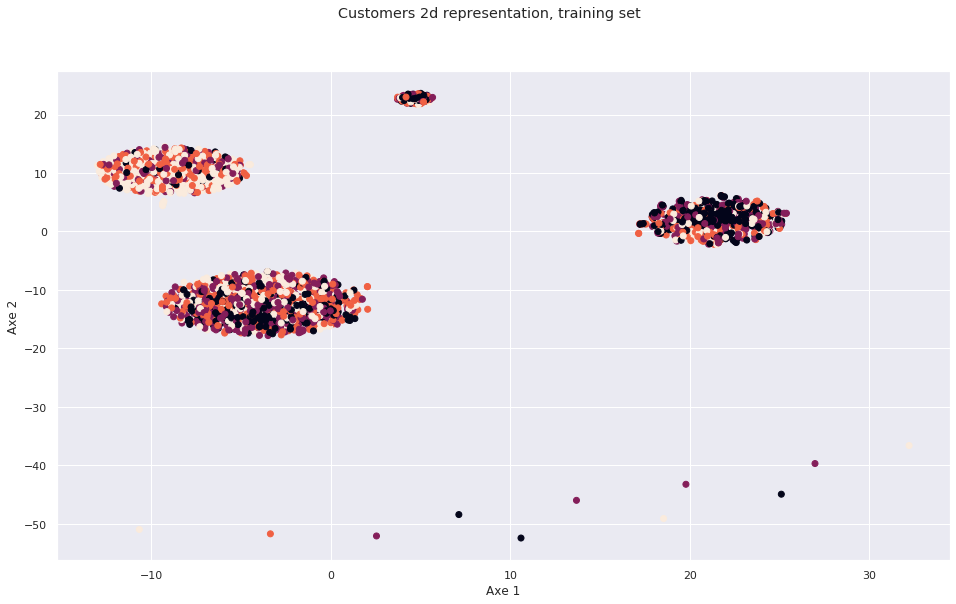

In [140]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [141]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_pca_allfeats_final_tsne.html') 

'clusters_plot_clients_pca_allfeats_final_tsne.html'

# Model with all features and tSNE, final representation with tSNE

In [177]:
importlib.reload(sys.modules['functions'])
from functions import *

In [178]:
df_train = df_train_ori
df_test = df_test_ori

In [179]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='TSNE', n_dim=3)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [180]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Fit log scaler multiple
Transform log scaler scaler multiple
Fit Min max scaler multiple
Transform Min max scaler multiple
Fit Dimensionality Reductor
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNo

In [181]:
df_train

,BoughtTopValueProduct,TotalPricePerMonth,HasEverCancelled,0,1,2
0,1.0,0.877446,1.0,0.783543,0.628913,0.878636
1,1.0,0.572415,0.0,0.727786,0.430184,0.704302
2,0.0,0.474029,0.0,0.741093,0.560714,0.462285
3,1.0,0.707529,0.0,0.648290,0.514565,0.458161
4,0.0,0.330609,0.0,0.759664,0.587738,0.564628
...,...,...,...,...,...,...
4327,0.0,0.286691,0.0,0.747399,0.632402,0.684291
4328,0.0,0.265155,0.0,0.766730,0.647952,0.548147
4329,1.0,0.370964,1.0,0.716419,0.469840,0.643490
4330,1.0,0.505393,0.0,0.727965,0.528250,0.312737


In [182]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Data columns (total 6 columns):
BoughtTopValueProduct    4332 non-null float64
TotalPricePerMonth       4332 non-null float64
HasEverCancelled         4332 non-null float64
0                        4332 non-null float64
1                        4332 non-null float64
2                        4332 non-null float64
dtypes: float64(6)
memory usage: 203.2 KB


In [187]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [188]:
X_transformed[:,1]

array([-12.465547,  20.816553, -38.893944, ...,  -5.508614,  51.804184,
       -56.67659 ], dtype=float32)

Text(0, 0.5, 'Axe 2')

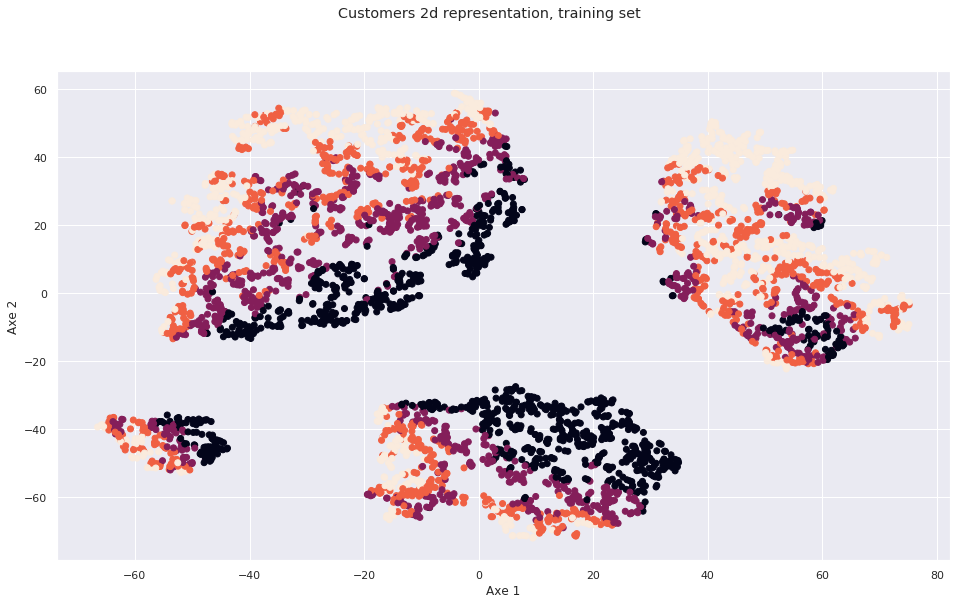

In [189]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [190]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_allfeats_final_tsne.html') 

'clusters_plot_clients_sne_allfeats_final_tsne.html'

# Model with all features and tSNE, final representation with tSNE 3D

In [191]:
importlib.reload(sys.modules['functions'])
from functions import *

In [192]:
df_train = df_train_ori
df_test = df_test_ori

In [193]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='TSNE', n_dim=3)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [194]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Fit log scaler multiple
Transform log scaler scaler multiple
Fit Min max scaler multiple
Transform Min max scaler multiple
Fit Dimensionality Reductor
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNo

In [195]:
df_train

,BoughtTopValueProduct,TotalPricePerMonth,HasEverCancelled,0,1,2
0,1.0,0.877446,1.0,0.783543,0.628913,0.878636
1,1.0,0.572415,0.0,0.727786,0.430184,0.704302
2,0.0,0.474029,0.0,0.741093,0.560714,0.462285
3,1.0,0.707529,0.0,0.648290,0.514565,0.458161
4,0.0,0.330609,0.0,0.759664,0.587738,0.564628
...,...,...,...,...,...,...
4327,0.0,0.286691,0.0,0.747399,0.632402,0.684291
4328,0.0,0.265155,0.0,0.766730,0.647952,0.548147
4329,1.0,0.370964,1.0,0.716419,0.469840,0.643490
4330,1.0,0.505393,0.0,0.727965,0.528250,0.312737


In [196]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Data columns (total 6 columns):
BoughtTopValueProduct    4332 non-null float64
TotalPricePerMonth       4332 non-null float64
HasEverCancelled         4332 non-null float64
0                        4332 non-null float64
1                        4332 non-null float64
2                        4332 non-null float64
dtypes: float64(6)
memory usage: 203.2 KB


In [197]:
tsne = TSNE(n_components=3, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [198]:
X_transformed[:,1]

array([-7.9212937,  3.8351228, -2.1941373, ..., -7.4698176, 13.077991 ,
        4.946701 ], dtype=float32)

In [201]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter3d(x = X_transformed[:,0], y = X_transformed[:,1], z = X_transformed[:,2],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 3 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_allfeats_final_tsne_3d.html') 

'clusters_plot_clients_sne_allfeats_final_tsne_3d.html'

# Annex

## Display some data

In [26]:
df_nocancel = df[df['InvoiceNo'].str.startswith('C') == False]
df_nocancel.reset_index(inplace=True)

df_gbproduct = df_nocancel[['StockCode', 'TotalPrice']].groupby('StockCode').sum()['TotalPrice']

In [27]:
df_nocancel.head(2)

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,DescriptionNormalized,InvoiceMonth
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,WHITE HANGING HEART T-LIGHT HOLDER,2010-12-01 00:00:00
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,WHITE METAL LANTERN,2010-12-01 00:00:00


In [28]:
df_nocancel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391328 entries, 0 to 391327
Data columns (total 12 columns):
index                    391328 non-null int64
InvoiceNo                391328 non-null object
StockCode                391328 non-null object
Description              391328 non-null object
Quantity                 391328 non-null int64
InvoiceDate              391328 non-null object
UnitPrice                391328 non-null float64
CustomerID               391328 non-null object
Country                  391328 non-null object
TotalPrice               391328 non-null float64
DescriptionNormalized    391328 non-null object
InvoiceMonth             391328 non-null object
dtypes: float64(2), int64(2), object(8)
memory usage: 35.8+ MB


In [29]:
invoice_dates = pd.to_datetime(df_nocancel["InvoiceDate"], format="%Y-%m-%d ")

In [30]:
invoice_dates = pd.to_datetime(df_nocancel["InvoiceDate"])

In [31]:
np.maximum((pd.to_datetime('2011-12-09 12:50:00') - invoice_dates) / (np.timedelta64(1, "M")), 1)[123456]

6.997862150945377

In [32]:
df_gbcustom_firstorder = df_nocancel[['CustomerID', 'InvoiceDate']].groupby('CustomerID').min()

In [33]:
df_nocancel[['CustomerID', 'InvoiceDate']].groupby('CustomerID').min()['InvoiceDate']

CustomerID
12346    2011-01-18 10:01:00
12347    2010-12-07 14:57:00
12348    2010-12-16 19:09:00
12349    2011-11-21 09:51:00
12350    2011-02-02 16:01:00
                ...         
18280    2011-03-07 09:52:00
18281    2011-06-12 10:53:00
18282    2011-08-05 13:35:00
18283    2011-01-06 14:14:00
18287    2011-05-22 10:39:00
Name: InvoiceDate, Length: 4336, dtype: object

In [34]:
(\
   pd.to_datetime('2011-12-09 12:50:00')\
   - pd.to_datetime(df_nocancel[['CustomerID', 'InvoiceDate']].groupby('CustomerID').min()['InvoiceDate'])
)\
  / (np.timedelta64(1, "M"))

CustomerID
12346    10.681693
12347    12.054845
12348    11.753401
12349     0.595472
12350    10.180656
           ...    
18280     9.104864
18281     5.916549
18282     4.138689
18283    11.070179
18287     6.606821
Name: InvoiceDate, Length: 4336, dtype: float64

In [35]:
# Number of months between first order date and last date of the dataset
series_gbclient_nbmonths = np.maximum(\
(
   (
   pd.to_datetime('2011-12-09 12:50:00')\
   - pd.to_datetime(df_nocancel[['CustomerID', 'InvoiceDate']].groupby('CustomerID').min()['InvoiceDate'])
   )\
    / (np.timedelta64(1, "M"))
), 1)

In [36]:
df_nocancel[['CustomerID', ]]

,CustomerID
0,17850
1,17850
2,17850
3,17850
4,17850
...,...
391323,12680
391324,12680
391325,12680
391326,12680


In [37]:
df_gbcustom_firstorder

,InvoiceDate
CustomerID,
12346,2011-01-18 10:01:00
12347,2010-12-07 14:57:00
12348,2010-12-16 19:09:00
12349,2011-11-21 09:51:00
12350,2011-02-02 16:01:00
...,...
18280,2011-03-07 09:52:00
18281,2011-06-12 10:53:00
18282,2011-08-05 13:35:00


In [38]:
df_nocancel[df_nocancel['CustomerID'] == '18281'].sort_values(by='InvoiceDate', ascending=True)

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,DescriptionNormalized,InvoiceMonth
153118,156809,556464,22037,ROBOT BIRTHDAY CARD,12,2011-06-12 10:53:00,0.42,18281,United Kingdom,5.04,ROBOT BIRTHDAY CARD,2011-06-01 00:00:00
153119,156810,556464,22716,CARD CIRCUS PARADE,12,2011-06-12 10:53:00,0.42,18281,United Kingdom,5.04,CARD CIRCUS PARADE,2011-06-01 00:00:00
153120,156811,556464,22028,PENNY FARTHING BIRTHDAY CARD,12,2011-06-12 10:53:00,0.42,18281,United Kingdom,5.04,PENNY FARTHING BIRTHDAY CARD,2011-06-01 00:00:00
153121,156812,556464,23007,SPACEBOY BABY GIFT SET,1,2011-06-12 10:53:00,16.95,18281,United Kingdom,16.95,SPACEBOY BABY GIFT SET,2011-06-01 00:00:00
153122,156813,556464,23008,DOLLY GIRL BABY GIFT SET,1,2011-06-12 10:53:00,16.95,18281,United Kingdom,16.95,DOLLY GIRL BABY GIFT SET,2011-06-01 00:00:00
153123,156814,556464,23209,LUNCH BAG DOILEY PATTERN,10,2011-06-12 10:53:00,1.65,18281,United Kingdom,16.50,LUNCH BAG VINTAGE DOILY,2011-06-01 00:00:00
153124,156815,556464,22467,GUMBALL COAT RACK,6,2011-06-12 10:53:00,2.55,18281,United Kingdom,15.30,GUMBALL COAT RACK,2011-06-01 00:00:00


In [39]:
invoice_dates[2000:2010]

2000   2010-12-02 09:43:00
2001   2010-12-02 09:43:00
2002   2010-12-02 09:43:00
2003   2010-12-02 09:43:00
2004   2010-12-02 09:43:00
2005   2010-12-02 09:43:00
2006   2010-12-02 09:43:00
2007   2010-12-02 09:43:00
2008   2010-12-02 09:44:00
2009   2010-12-02 09:44:00
Name: InvoiceDate, dtype: datetime64[ns]

In [40]:
df_nocancel.loc[2000:2010,'InvoiceDate']

2000    2010-12-02 09:43:00
2001    2010-12-02 09:43:00
2002    2010-12-02 09:43:00
2003    2010-12-02 09:43:00
2004    2010-12-02 09:43:00
2005    2010-12-02 09:43:00
2006    2010-12-02 09:43:00
2007    2010-12-02 09:43:00
2008    2010-12-02 09:44:00
2009    2010-12-02 09:44:00
2010    2010-12-02 09:44:00
Name: InvoiceDate, dtype: object

In [41]:
df_nocancel.loc[100000:100010,'InvoiceMonth']

100000    2011-04-01 00:00:00
100001    2011-04-01 00:00:00
100002    2011-04-01 00:00:00
100003    2011-04-01 00:00:00
100004    2011-04-01 00:00:00
100005    2011-04-01 00:00:00
100006    2011-04-01 00:00:00
100007    2011-04-01 00:00:00
100008    2011-04-01 00:00:00
100009    2011-04-01 00:00:00
100010    2011-04-01 00:00:00
Name: InvoiceMonth, dtype: object

In [42]:
df[df['InvoiceNo'].str.startswith('C') == True]['CustomerID'].unique()

array(['14527', '15311', '17548', ..., '12985', '15951', '16446'],
      dtype=object)

In [43]:
# Product codes that contain chars instead of numbers
df[df['StockCode'].str.isalpha()]['StockCode'].unique()

array(['D'], dtype=object)

# For debug / test (clean code is in functions.py)

In [44]:
df_train = df_train_ori
df_test = df_test_ori

In [45]:
df_train.head(6)

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,DescriptionNormalized,InvoiceMonth
0,11503,537781,21377,SMALL CAMPHOR WOOD FIELD MUSHROOM,1,2010-12-08 12:46:00,1.65,17341,United Kingdom,1.65,SMALL CAMPHOR WOOD FIELD MUSHROOM,2010-12-01 00:00:00
1,40887,541855,21947,SET OF 6 HEART CHOPSTICKS,1,2011-01-23 14:59:00,1.25,13742,United Kingdom,1.25,SET OF 6 HEART CHOPSTICKS,2011-01-01 00:00:00
2,103799,549646,85031A,ROMANTIC IMAGES SCRAP BOOK SET,6,2011-04-11 11:51:00,1.25,12982,United Kingdom,7.50,ROMANTIC IMAGES SCRAP BOOK SET,2011-04-01 00:00:00
3,372911,578856,23535,WALL ART BICYCLE SAFETY,4,2011-11-27 11:18:00,5.95,17769,United Kingdom,23.80,WALL ART BICYCLE SAFETY,2011-11-01 00:00:00
4,297823,571747,23396,LE JARDIN BOTANIQUE CUSHION COVER,4,2011-10-19 10:59:00,3.75,13849,United Kingdom,15.00,LE JARDIN BOTANIQUE CUSHION COVER,2011-10-01 00:00:00
5,359556,577535,21098,CHRISTMAS TOILET ROLL,3,2011-11-20 14:07:00,1.25,14071,United Kingdom,3.75,CHRISTMAS TOILET ROLL,2011-11-01 00:00:00


In [46]:
df_train

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,DescriptionNormalized,InvoiceMonth
0,11503,537781,21377,SMALL CAMPHOR WOOD FIELD MUSHROOM,1,2010-12-08 12:46:00,1.65,17341,United Kingdom,1.65,SMALL CAMPHOR WOOD FIELD MUSHROOM,2010-12-01 00:00:00
1,40887,541855,21947,SET OF 6 HEART CHOPSTICKS,1,2011-01-23 14:59:00,1.25,13742,United Kingdom,1.25,SET OF 6 HEART CHOPSTICKS,2011-01-01 00:00:00
2,103799,549646,85031A,ROMANTIC IMAGES SCRAP BOOK SET,6,2011-04-11 11:51:00,1.25,12982,United Kingdom,7.50,ROMANTIC IMAGES SCRAP BOOK SET,2011-04-01 00:00:00
3,372911,578856,23535,WALL ART BICYCLE SAFETY,4,2011-11-27 11:18:00,5.95,17769,United Kingdom,23.80,WALL ART BICYCLE SAFETY,2011-11-01 00:00:00
4,297823,571747,23396,LE JARDIN BOTANIQUE CUSHION COVER,4,2011-10-19 10:59:00,3.75,13849,United Kingdom,15.00,LE JARDIN BOTANIQUE CUSHION COVER,2011-10-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
359915,128343,552843,22692,DOORMAT WELCOME TO OUR HOME,1,2011-05-11 14:37:00,7.95,14649,United Kingdom,7.95,DOORMAT WELCOME TO OUR HOME,2011-05-01 00:00:00
359916,272049,569401,23356,LOVE HOT WATER BOTTLE,3,2011-10-04 08:56:00,5.95,15111,United Kingdom,17.85,LOVE HOT WATER BOTTLE,2011-10-01 00:00:00
359917,225276,564554,23280,FOLDING BUTTERFLY MIRROR HOT PINK,1,2011-08-25 19:39:00,0.83,17189,United Kingdom,0.83,FOLDING BUTTERFLY MIRROR HOT PINK,2011-08-01 00:00:00
359918,302898,572274,22423,REGENCY CAKESTAND 3 TIER,16,2011-10-21 16:48:00,10.95,14031,United Kingdom,175.20,REGENCY CAKESTAND 3 TIER,2011-10-01 00:00:00


In [47]:
df_train_nocancel = df_train[df_train['InvoiceNo'].str.startswith('C') == False]
df_train_nocancel.reset_index(inplace=True)

In [48]:
feat_list = ['CustomerID', 'TotalPrice']
feat_list_bow = [col for col in df_train_nocancel if col.startswith('DescriptionNormalized_')]
feat_list.extend(feat_list_bow)

In [49]:
feat_list

['CustomerID', 'TotalPrice']

In [50]:
df_train_gbcust_nocancel = df_train_nocancel[feat_list].groupby('CustomerID').sum()

In [51]:
df_train_gbcust_nocancel[feat_list_bow] = df_train_gbcust_nocancel[feat_list_bow].clip(upper=1)

In [52]:
df_train_gbcust_nocancel

,TotalPrice
CustomerID,
12346,77183.60
12347,3956.22
12348,1416.84
12349,1292.19
12350,279.40
...,...
18280,156.90
18281,80.82
18282,173.01


In [53]:
# Number of months between first order date and last date of the dataset
series_train_gbclient_nbmonths = np.maximum(\
(
   (
   pd.to_datetime('2011-12-09 12:50:00')\
   - pd.to_datetime(df_train_nocancel[['CustomerID', 'InvoiceDate']].groupby('CustomerID').min()['InvoiceDate'])
   )\
    / (np.timedelta64(1, "M"))
), 1)

In [54]:
series_train_gbclient_nbmonths

CustomerID
12346    10.681693
12347    12.054845
12348    11.753401
12349     1.000000
12350    10.180656
           ...    
18280     9.104864
18281     5.916549
18282     4.138689
18283    11.070179
18287     6.606821
Name: InvoiceDate, Length: 4332, dtype: float64

In [55]:
df_train_gbcust_nocancel['TotalPrice'] 

CustomerID
12346    77183.60
12347     3956.22
12348     1416.84
12349     1292.19
12350      279.40
           ...   
18280      156.90
18281       80.82
18282      173.01
18283     1837.51
18287     1684.52
Name: TotalPrice, Length: 4332, dtype: float64

In [56]:
df_train_gbcust_nocancel['TotalPrice'] = df_train_gbcust_nocancel['TotalPrice'] / series_train_gbclient_nbmonths

In [57]:
df_train_gbcust_nocancel

,TotalPrice
CustomerID,
12346,7225.783259
12347,328.185062
12348,120.547233
12349,1292.190000
12350,27.444203
...,...
18280,17.232547
18281,13.659991
18282,41.803096


In [58]:
df_train

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,DescriptionNormalized,InvoiceMonth
0,11503,537781,21377,SMALL CAMPHOR WOOD FIELD MUSHROOM,1,2010-12-08 12:46:00,1.65,17341,United Kingdom,1.65,SMALL CAMPHOR WOOD FIELD MUSHROOM,2010-12-01 00:00:00
1,40887,541855,21947,SET OF 6 HEART CHOPSTICKS,1,2011-01-23 14:59:00,1.25,13742,United Kingdom,1.25,SET OF 6 HEART CHOPSTICKS,2011-01-01 00:00:00
2,103799,549646,85031A,ROMANTIC IMAGES SCRAP BOOK SET,6,2011-04-11 11:51:00,1.25,12982,United Kingdom,7.50,ROMANTIC IMAGES SCRAP BOOK SET,2011-04-01 00:00:00
3,372911,578856,23535,WALL ART BICYCLE SAFETY,4,2011-11-27 11:18:00,5.95,17769,United Kingdom,23.80,WALL ART BICYCLE SAFETY,2011-11-01 00:00:00
4,297823,571747,23396,LE JARDIN BOTANIQUE CUSHION COVER,4,2011-10-19 10:59:00,3.75,13849,United Kingdom,15.00,LE JARDIN BOTANIQUE CUSHION COVER,2011-10-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
359915,128343,552843,22692,DOORMAT WELCOME TO OUR HOME,1,2011-05-11 14:37:00,7.95,14649,United Kingdom,7.95,DOORMAT WELCOME TO OUR HOME,2011-05-01 00:00:00
359916,272049,569401,23356,LOVE HOT WATER BOTTLE,3,2011-10-04 08:56:00,5.95,15111,United Kingdom,17.85,LOVE HOT WATER BOTTLE,2011-10-01 00:00:00
359917,225276,564554,23280,FOLDING BUTTERFLY MIRROR HOT PINK,1,2011-08-25 19:39:00,0.83,17189,United Kingdom,0.83,FOLDING BUTTERFLY MIRROR HOT PINK,2011-08-01 00:00:00
359918,302898,572274,22423,REGENCY CAKESTAND 3 TIER,16,2011-10-21 16:48:00,10.95,14031,United Kingdom,175.20,REGENCY CAKESTAND 3 TIER,2011-10-01 00:00:00


In [59]:
custid_cancelled = df_train[df_train['InvoiceNo'].str.startswith('C') == True]['CustomerID'].unique()